In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
from scipy import stats
import pandas_datareader as web
import plotly.express as px
import statsmodels.api as sm
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime as dt

Classification problem: Stock data

Stock data from python package was chosen for the linear regression modeling. 

In [2]:
# Import stock data from Naver from the specified dates
start_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2019, 12, 31)
data = web.DataReader('005930', 'naver', start_date, end_date)

data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,39400,39400,38550,38750,7847664
2019-01-03,38300,38550,37450,37600,12471493
2019-01-04,37450,37600,36850,37450,14108958
2019-01-07,38000,38900,37800,38750,12748997
2019-01-08,38000,39200,37950,38100,12756554


In [3]:
# Write the code for linear regression
class linear_regression():
    def __init__(self):
        self.X = None
        self.variables = None
        self.y = None
        self.predictor = None
        self.n = None
        self.p = None
        self.bias = None
        self.beta_hat = None
        self.y_hat = None

    # model fitting
    def fit(self, X, y, bias=True):
        self.variables = X.columns
        self.predictor = y.name
        
        X = X.to_numpy()
        y = y.to_numpy()

        if bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)

        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.bias = bias


        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        self.beta_hat = beta_hat
        self.y_hat = X @ beta_hat

    # predict new data
    def predict(self, x):
        if self.bias:
            ones_column = np.ones((x.shape[0], 1))
            x = np.append(ones_column, x, axis=1)
        return x @ self.beta_hat

    # function of sum of squared errors
    def SSE(self):
        return (self.y-self.y_hat).T@(self.y-self.y_hat)
    
    # function of mean squared errors
    def MSE(self):
        return self.SSE()/(self.n-self.p)

    # function of sum of squares regression
    def SSR(self):
        return (self.y_hat - np.mean(self.y)).T @ (self.y_hat - np.mean(self.y))

    # function of mean squared regression
    def MSR(self):
        return self.SSR()/(self.p-1)

    # function of sum of squares total
    def SST(self):
        return (self.y-np.mean(self.y_hat)).T@(self.y-np.mean(self.y_hat))

    # function of coefficient of determination
    def R_2(self):
        return 1 - self.SSE()/self.SST()

    # function of coefficient of determination on test data
    def pred_R_2(self, input, true):
        pred = self.predict(input)
        pred_SSE = (true-pred).T@(true-pred)
        pred_SST = (true-np.mean(pred)).T@(true-np.mean(pred))
        return 1 - pred_SSE/pred_SST

    # function of adjusted coefficient of determination
    def adj_R_2(self):
        return 1- (1-self.R_2())*(self.n-1)/(self.n-self.p-1)

    # function of standard deviation of coefficients
    def sd_coef(self):
        return np.sqrt(np.diagonal(self.MSE() * np.linalg.inv(self.X.T @ self.X)))

    # function of t statistic and p-value
    def t_stat(self):
        t = self.beta_hat / self.sd_coef()
        t_p = [2*(1-stats.t.cdf(np.abs(i), (self.n-self.p-1))) for i in t]
        return t, t_p

    # function of F statistic and p-value
    def F_stat(self):
        F = self.MSR()/self.MSE()
        df_1 = self.p - 1
        df_2 = self.n - self.p
        #find p-value of F test statistic 
        F_p = 1-stats.f.cdf(F, df_1, df_2) 
        return F, F_p

    # function of root mean square error
    def RMSE(self, input, true):
        pred = self.predict(input)
        return np.sqrt((true-pred).T@(true-pred)/len(true))

    # function of model summary
    def summary(self):
        coef_df = pd.DataFrame()
        
        coef_df['Estimate'] = self.beta_hat
        coef_df['Std.Error'] = self.sd_coef()
        coef_df['t value'] = self.t_stat()[0]
        coef_df['Pr(>|t|)'] = self.t_stat()[1]
        coef_df.index = ['Intercept'] + list(self.variables)

        print(coef_df)

        print(f"Residual standard error: {round(np.sqrt(self.MSE()), 3)} on {self.n-self.p} degress of freedom.")
        print(f"R-squared: {round(self.R_2(), 3)}, Adjusted R-square: {round(self.adj_R_2(), 3)}")
        f_stat_str = f"F-statistic: {round(self.F_stat()[0], 3)} on {self.p - 1} and {self.n - self.p} DF,"
        f_p_str = f"p-value: {round(self.F_stat()[1], 3)}"
        print(f_stat_str + f_p_str)

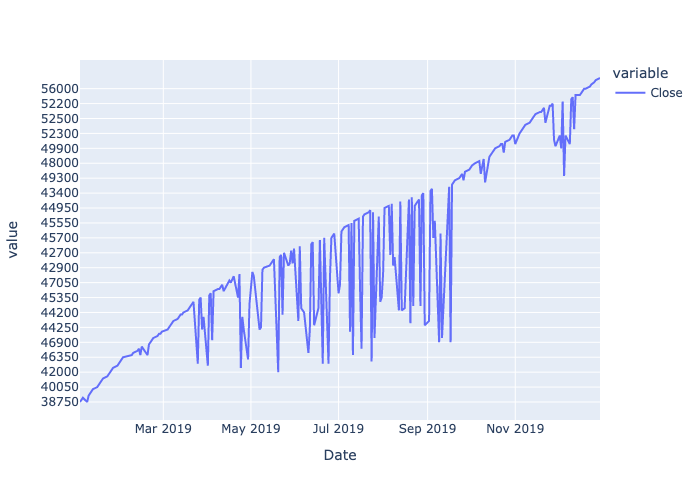

In [4]:
# Plot the close price of the data at the selected date
all_df = pd.DataFrame(data['Close'])

fig = px.line(all_df)
fig.show("png")

In [5]:
# Use the past 7 days to predict the current
for i in range(1, 8):
    all_df[f'lag_{i}'] = all_df['Close'].shift(i)
    
all_df.head(10)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2019-01-02,38750,None,None,None,None,None,None,None
2019-01-03,37600,38750,None,None,None,None,None,None
2019-01-04,37450,37600,38750,None,None,None,None,None
2019-01-07,38750,37450,37600,38750,None,None,None,None
2019-01-08,38100,38750,37450,37600,38750,None,None,None
2019-01-09,39600,38100,38750,37450,37600,38750,None,None
2019-01-10,39800,39600,38100,38750,37450,37600,38750,None
2019-01-11,40500,39800,39600,38100,38750,37450,37600,38750
2019-01-14,40050,40500,39800,39600,38100,38750,37450,37600


In [6]:
all_df.dropna(inplace=True)
cols = [f'lag_{i}' for i in range(1, 8)]

train_df = all_df.iloc[0:181-7, :]
train_df.head(5)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2019-01-11,40500,39800,39600,38100,38750,37450,37600,38750
2019-01-14,40050,40500,39800,39600,38100,38750,37450,37600
2019-01-15,41100,40050,40500,39800,39600,38100,38750,37450
2019-01-16,41450,41100,40050,40500,39800,39600,38100,38750
2019-01-17,41950,41450,41100,40050,40500,39800,39600,38100


In [7]:
# Train the model
X = train_df[cols]
y = train_df['Close']
model = linear_regression()
X = X.astype('int')
y = y.astype('int')
model.fit(X, y)
model.summary()

              Estimate    Std.Error    t value  Pr(>|t|)
Intercept  3817.273833  1274.401394   2.995347  0.003164
lag_1         1.022849     0.077574  13.185486  0.000000
lag_2        -0.042079     0.110557  -0.380612  0.703981
lag_3        -0.027002     0.108110  -0.249762  0.803082
lag_4        -0.124357     0.106085  -1.172247  0.242788
lag_5         0.157724     0.106422   1.482066  0.140230
lag_6        -0.071856     0.106947  -0.671886  0.502596
lag_7         0.000701     0.074792   0.009377  0.992530
Residual standard error: 636.084 on 166 degress of freedom.
R-squared: 0.878, Adjusted R-square: 0.872
F-statistic: 170.124 on 7 and 166 DF,p-value: 0.0


In [8]:
RMSE = model.RMSE(X, y)
print(f"The RMSE of training data is: {round(RMSE, 3)}")

The RMSE of training data is: 621.289


The R-squared value is 0.872 which is not bad. The RMSE is 621.29 is not bad considering that the values of the dataset are 5 digits. 

/var/folders/dh/58sn147x6rd88mqnrh69_th80000gn/T/ipykernel_11968/2433450901.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/dh/58sn147x6rd88mqnrh69_th80000gn/T/ipykernel_11968/2433450901.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



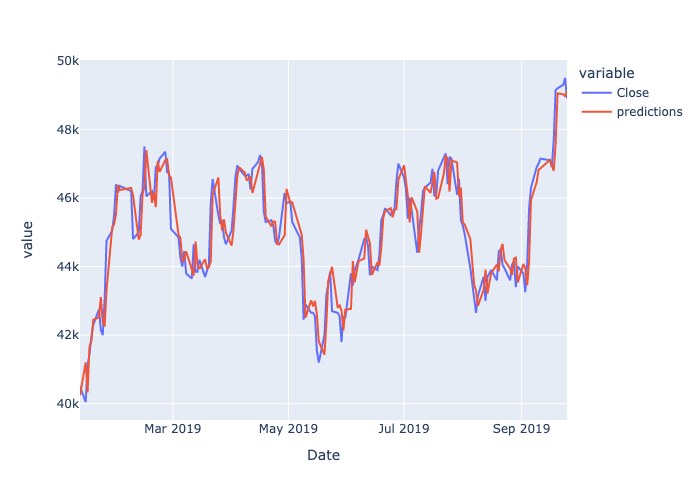

In [9]:
train_df['predictions'] = model.predict(X).astype('float')
train_df['Close'] = train_df['Close'].astype('float')

fig = px.line(train_df, y=['Close','predictions'])


fig.show("png")

In [10]:
X_n = sm.add_constant(X)
sm.OLS(y, X_n).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     170.1
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           2.67e-72
Time:                        11:29:40   Log-Likelihood:                -1366.0
No. Observations:                 174   AIC:                             2748.
Df Residuals:                     166   BIC:                             2773.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3817.2738   1274.401      2.995      0.003    1301.150    6333.398
lag_1          1.0228      0.078     13.185      0.000       0.870       1.176
lag_2         -0.0421      0.111     -0.381      0.704      -0.260       0.176
lag_3         -0.0270      0.108     -0.250      0.803      -0.240       0.186
lag_4         -0.1244      0.106     -1.172      0.243      -0.334       0.085
lag_5          0.1577      0.106      1.482      0.140      -0.052       0.368
lag_6         -0.0719      0.107     -0.672      0.503      -0.283       0.139
lag_7          0.0007      0.075      0.009      0.993      -0.147       0.148
==============================================================================
Omnibus:                        0.610   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.737   Jarque-Bera (JB):                0.299
Skew:                          -0.021   Prob(JB):                        0.861
Kurtosis:                       3.198   Cond. No.                     3.13e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear Regression Modeling Results for Stock Data

### Interpretation

- **R-squared (R2):** 0.878 indicates that approximately 87.8% of the variance in the dependent variable (Close price) is explained by the independent variables (lag_1, lag_2, ..., lag_7).

- **F-statistic:** The high F-statistic value of 170.1 and low associated p-value (2.67e-72) indicate that the overall regression model is statistically significant.

- **Coefficients:** The coefficient estimates for the lagged variables (lag_1, lag_2, ..., lag_7) represent the change in the dependent variable (Close price) for a one-unit change in each independent variable, holding other variables constant.

- **Interpretation of Coefficients:** For example, the coefficient for lag_1 is 1.0228, indicating that a one-unit increase in lag_1 is associated with a $1.0228 increase in the Close price.

### Assumptions and Diagnostics

- **Omnibus Test:** The Omnibus test tests for the normality of residuals. A p-value greater than 0.05 (0.737) suggests that the residuals are normally distributed.

- **Durbin-Watson:** The Durbin-Watson statistic tests for autocorrelation of residuals. A value close to 2 (1.995) indicates no significant autocorrelation.

- **Jarque-Bera (JB) Test:** The JB test tests for the skewness and kurtosis of residuals. A p-value greater than 0.05 (0.861) suggests that the residuals are normally distributed.

Overall, the linear regression model provides a good fit to the data, with a high R-squared value and statistically significant coefficients.
